# Example: Automated ML for time series predicion

We used one of the dataset in Numenta Anomaly Benchmark (NAB) ([link](https://github.com/numenta/NAB)) for demo, i.e. NYC taxi passengers dataset, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot. We use RNN to learn from 50 previous values, and predict just the 1 next value. 

## 0 Helper function definitions

In [59]:
#min max scale
def scale_df(data):
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(data)
    data_n = pd.DataFrame(np_scaled)
    return data_n, min_max_scaler

In [9]:
#prepare train and test data
def prepare_data(data,train_len=50,pred_len=1):
    # data in format of dataframe
    def split_train_test(dataframe, train_len, pred_len,test_ratio = 0.1):
        testdatasize = int(len(dataframe) * test_ratio)
        testdatacut = testdatasize + train_len  + 1
        #train data
        x_train = dataframe[0:-pred_len-testdatacut].values
        y_train = dataframe[pred_len:-testdatacut  ][0].values
        #test data
        x_test = dataframe[0-testdatacut:-pred_len].values
        y_test = dataframe[pred_len-testdatacut:  ][0].values
        return (x_train, y_train), (x_test, y_test)
    #unroll: create sequence of 50 previous data points for each data points
    def unroll(data,sequence_len):
        result = []
        for index in range(len(data) - sequence_len):
            result.append(data[index: index + sequence_len])
        return np.asarray(result)
    #important parameters and train/test size, 
    (x_train,y_train),(x_test,y_test) = split_train_test(data, train_len, pred_len)
    # adapt the datasets for the sequence data shape
    x_train = unroll(x_train,train_len)
    x_test  = unroll(x_test,train_len)
    y_train = y_train[-x_train.shape[0]:]
    y_test  = y_test[-x_test.shape[0]:]
    return (x_train,y_train), (x_test,y_test)

In [10]:
# build model
def build_model(input_shape_x,inputshape_y,out_units=1,lr=0.001,lstm_1_units=20,dropout_1=0.2,lstm_2_units=10,dropout_2=0.2):
    # Build the model
    model = Sequential()
    model.add(LSTM(
        input_shape=(input_shape_x,inputshape_y),
        units=lstm_1_units,
        return_sequences=True))
    model.add(Dropout(dropout_1))

    model.add(LSTM(
        units = lstm_2_units,
        return_sequences=False))
    model.add(Dropout(dropout_2))
    
    model.add(Dense(units=out_units))
    model.compile(loss='mse',metrics=['mse'], optimizer=keras.optimizers.RMSprop(lr=lr))
    return model

In [11]:
# plot the predicted values and actual values (for the test data)
def plot_result(y_true, y_pred):
    fig, axs = plt.subplots()

    axs.plot(y_pred,color='red', label='predicted values')
    axs.plot(y_true,color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel('test data index')
    plt.ylabel('number of taxi passengers after min_max_scalar')
    plt.legend(loc='upper left')
    plt.show()

In [12]:
def get_best_trial(trial_list, metric):
    """Retrieve the best trial."""
    return max(trial_list, key=lambda trial: trial.last_result.get(metric, 0))


def get_sorted_trials(trial_list, metric):
    return sorted(
        trial_list,
        key=lambda trial: trial.last_result.get(metric, 0),
        reverse=True)


def get_best_result(trial_list, metric):
    """Retrieve the last result from the best trial."""
    return {metric: get_best_trial(trial_list, metric).last_result[metric]}


## 1 Normal process for modeling/feature/evalution

### 1.1 load data

In [1]:
import os

import pandas as pd
import numpy as np
import keras

import matplotlib
matplotlib.use('Agg')
%pylab inline
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [3]:
try:
    dataset_path = "data/nyc_taxi.csv"
    df_original = pd.read_csv(dataset_path)
except Exception as e:
    print("nyc_taxi.csv doesn't exist")
    print("you can run $ANALYTICS_ZOO_HOME/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh to download nyc_taxi.csv")

In [4]:
df_original.describe()

,value
count,10320.000000
mean,15137.569380
std,6939.495808
min,8.000000
25%,10262.000000
50%,16778.000000
75%,19838.750000
max,39197.000000


In [5]:
df_original.head(5)

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


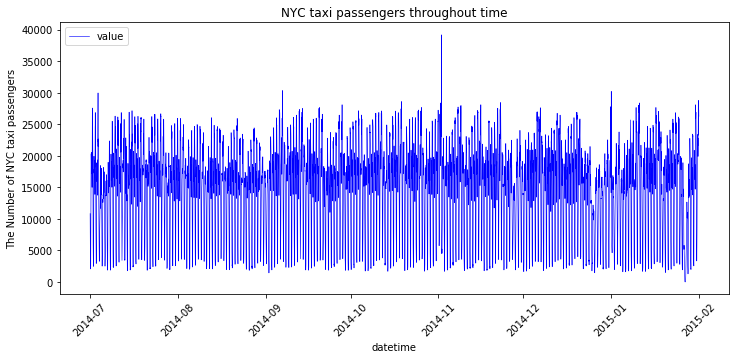

In [6]:
# change the type of timestamp column for plotting
df_original['datetime'] = pd.to_datetime(df_original['timestamp'])

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_original['datetime'], df_original['value'], color='blue', linewidth=0.6)
ax.set_title('NYC taxi passengers throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('The Number of NYC taxi passengers')
plt.legend(loc='upper left')
plt.show()

In [7]:
df_original.head(5)

,timestamp,value,datetime
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00


### 1.2 exploratory Data analysis for feature engineering 

In [13]:
df = df_original.copy()

In [14]:
# the hours when people are awake (6:00-00:00)
df['hours'] = df['datetime'].dt.hour
df['awake'] = (((df['hours'] >= 6) & (df['hours'] <= 23)) | (df['hours'] == 0)).astype(int)

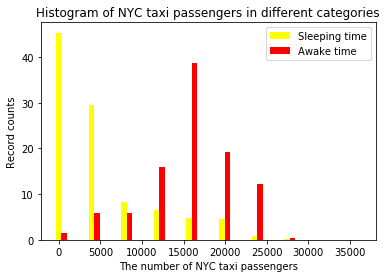

In [15]:
# creation of 2 distinct categories that seem useful (sleeping time and awake time)

a = df.loc[df['awake'] == 0, 'value']
b = df.loc[df['awake'] == 1, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='yellow', label='Sleeping time')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='red', label ='Awake time')
ax.set_title('Histogram of NYC taxi passengers in different categories')

plt.xlabel('The number of NYC taxi passengers')
plt.ylabel('Record counts')
plt.legend()
plt.show()

In [16]:
df.head(5)

,timestamp,value,datetime,hours,awake
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00,0,1
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00,0,1
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00,1,0
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00,1,0
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00,2,0


### 1.3 hand-select features and prepare train/test data

In [17]:
#select and standardize data
data_n = df[['value', 'hours', 'awake']]
data_n,_ = scale_df(data_n)
(x_train,y_train), (x_test,y_test) = prepare_data(data_n)

/home/shane/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/shane/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [18]:
# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (9186, 50, 3)
y_train (9186,)
x_test (1032, 50, 3)
y_test (1032,)


### 1.4 build and train model

In [19]:
inputshape_x = x_train.shape[1]
inputshape_y = x_train.shape[-1]
model = build_model(inputshape_x,inputshape_y)

In [20]:
%%time
# Train the model
print("Training begins.")
model.fit(
    x_train,
    y_train,
    batch_size=1024,
    epochs=20,
    validation_data=(x_test,y_test))
print("Training completed.")

Training begins.
Train on 9186 samples, validate on 1032 samples
Epoch 1/20
9186/9186 [==============================] - 2s 168us/step - loss: 0.9330 - mean_squared_error: 0.9330 - val_loss: 0.9418 - val_mean_squared_error: 0.9418
Epoch 2/20
9186/9186 [==============================] - 1s 84us/step - loss: 0.7080 - mean_squared_error: 0.7080 - val_loss: 0.7458 - val_mean_squared_error: 0.7458
Epoch 3/20
9186/9186 [==============================] - 1s 84us/step - loss: 0.5433 - mean_squared_error: 0.5433 - val_loss: 0.5870 - val_mean_squared_error: 0.5870
Epoch 4/20
9186/9186 [==============================] - 1s 84us/step - loss: 0.4213 - mean_squared_error: 0.4213 - val_loss: 0.4826 - val_mean_squared_error: 0.4826
Epoch 5/20
9186/9186 [==============================] - 1s 84us/step - loss: 0.3453 - mean_squared_error: 0.3453 - val_loss: 0.4091 - val_mean_squared_error: 0.4091
Epoch 6/20
9186/9186 [==============================] - 1s 84us/step - loss: 0.3055 - mean_squared_error: 0.3

### 1.5 model evaluation

In [21]:
pred_test = model.predict(x_test)

In [22]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,pred_test)
print("the mean squared error on test set is :", mse)

the mean squared error on test set is : 0.21057399391330503


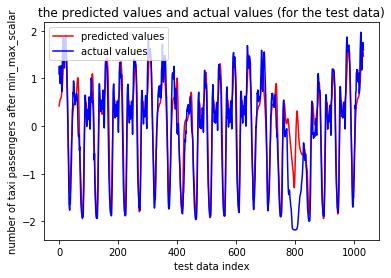

In [23]:
# plot the predicted values and actual values (for the test data)
plot_result(y_test,pred_test)

## 2 auto feature engineering

### 2.1 feature matrix preparation

In [24]:
df = df_original[["datetime","value"]].copy()

In [25]:
df["id"] = df.index + 1 # needed for featuretools

In [26]:
import featuretools as ft

In [27]:
df.head()

,datetime,value,id
0,2014-07-01 00:00:00,10844,1
1,2014-07-01 00:30:00,8127,2
2,2014-07-01 01:00:00,6210,3
3,2014-07-01 01:30:00,4656,4
4,2014-07-01 02:00:00,3820,5


In [28]:
es = ft.EntitySet(id="taxi_data")

In [29]:
es = es.entity_from_dataframe(entity_id="counts",
                              dataframe=df,
                              index="id",
                              time_index="datetime",
#                       variable_types={"id": ft.variable_types.Categorical,                                            }
                             )

In [30]:
es['counts'].variables

[<Variable: id (dtype = index)>,
 <Variable: datetime (dtype: datetime_time_index, format: None)>,
 <Variable: value (dtype = numeric)>]

In [31]:
#prims = ft.primitives.list_primitives()
#prims[prims["type"] == "transform"]

In [32]:
def is_awake(column):
    hour = column.dt.hour
    return (((hour >= 6) & (hour <= 23)) | (hour == 0)).astype(int)
def is_busy_hours(column):
    hour = column.dt.hour
    return (((hour >= 7) & (hour <= 9)) | (hour >= 16) & (hour <= 19)).astype(int)

In [33]:
from featuretools.primitives import make_agg_primitive, make_trans_primitive
from featuretools.variable_types import Text, Numeric, DatetimeTimeIndex
IsAwake = make_trans_primitive(function=is_awake,
                               input_types=[DatetimeTimeIndex],
                               return_type=Numeric)
IsBusyHours = make_trans_primitive(function=is_busy_hours,
                               input_types=[DatetimeTimeIndex],
                               return_type=Numeric)

In [34]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="counts",
                                      agg_primitives=["count"],
                                      trans_primitives=["month","weekday","day","hour","percentile","is_weekend",IsAwake,IsBusyHours])

In [35]:
feature_defs

[<Feature: value>,
 <Feature: MONTH(datetime)>,
 <Feature: WEEKDAY(datetime)>,
 <Feature: DAY(datetime)>,
 <Feature: HOUR(datetime)>,
 <Feature: PERCENTILE(value)>,
 <Feature: IS_WEEKEND(datetime)>,
 <Feature: IS_AWAKE(datetime)>,
 <Feature: IS_BUSY_HOURS(datetime)>]

In [36]:
feature_matrix.head(10)

,value,MONTH(datetime),WEEKDAY(datetime),DAY(datetime),HOUR(datetime),PERCENTILE(value),IS_WEEKEND(datetime),IS_AWAKE(datetime),IS_BUSY_HOURS(datetime)
id,,,,,,,,,
1,10844,7,1,1,0,0.260756,False,1,0
2,8127,7,1,1,0,0.220349,False,1,0
3,6210,7,1,1,1,0.176308,False,0,0
4,4656,7,1,1,1,0.137355,False,0,0
5,3820,7,1,1,2,0.103052,False,0,0
6,2873,7,1,1,2,0.062888,False,0,0
7,2369,7,1,1,3,0.034205,False,0,0
8,2064,7,1,1,3,0.016182,False,0,0
9,2221,7,1,1,4,0.024564,False,0,0


### 2.2 prepare train/test data

In [37]:
#select and standardize data
data_n = feature_matrix
data_n,_ = scale_df(data_n)
(x_train,y_train), (x_test,y_test) = prepare_data(data_n)

/home/shane/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/shane/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [38]:
# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (9186, 50, 9)
y_train (9186,)
x_test (1032, 50, 9)
y_test (1032,)


### 2.3 build and train model

In [39]:
inputshape_x = x_train.shape[1]
inputshape_y = x_train.shape[-1]
model = build_model(inputshape_x,inputshape_y)

In [40]:
%%time
# Train the model
print("Training begins.")
model.fit(
    x_train,
    y_train,
    batch_size=1024,
    epochs=20,
    validation_data=(x_test,y_test))
print("Training completed.")

Training begins.
Train on 9186 samples, validate on 1032 samples
Epoch 1/20
9186/9186 [==============================] - 2s 184us/step - loss: 0.8929 - mean_squared_error: 0.8929 - val_loss: 1.1037 - val_mean_squared_error: 1.1037
Epoch 2/20
9186/9186 [==============================] - 1s 86us/step - loss: 0.7315 - mean_squared_error: 0.7315 - val_loss: 1.0022 - val_mean_squared_error: 1.0022
Epoch 3/20
9186/9186 [==============================] - 1s 86us/step - loss: 0.6107 - mean_squared_error: 0.6107 - val_loss: 0.9025 - val_mean_squared_error: 0.9025
Epoch 4/20
9186/9186 [==============================] - 1s 85us/step - loss: 0.5113 - mean_squared_error: 0.5113 - val_loss: 0.7981 - val_mean_squared_error: 0.7981
Epoch 5/20
9186/9186 [==============================] - 1s 86us/step - loss: 0.4151 - mean_squared_error: 0.4151 - val_loss: 0.6992 - val_mean_squared_error: 0.6992
Epoch 6/20
9186/9186 [==============================] - 1s 85us/step - loss: 0.3454 - mean_squared_error: 0.3

### 2.4 model evaluation

evalutaion result on test data is not as good as hand selected features (seems there's overfitting). Usually not all feature generated are suitable for training and feature selection is still needed after using featuretools to auto generate features. 

In [41]:
pred_test = model.predict(x_test)

In [42]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,pred_test)
print("the mean squared error on test set is :", mse)

the mean squared error on test set is : 0.3059791188710129


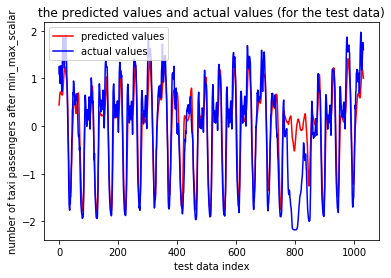

In [43]:
# plot the predicted values and actual values (for the test data)
plot_result(y_test,pred_test)


## 3 auto feature selection and hyper paramter tuning

### 3.1 initializations

limit the threads for Keras to avoid using up all the resources

In [44]:
from keras import backend as K
def limit_threads(num_threads):
    K.set_session(
        K.tf.Session(
            config=K.tf.ConfigProto(
                intra_op_parallelism_threads=num_threads,
                inter_op_parallelism_threads=num_threads)))

In [45]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import ray
import time
import keras

In [46]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
limit_threads(4)

In [47]:
ray.init(num_cpus=6, include_webui=False, ignore_reinit_error=True)

2019-04-29 11:32:00,299	WARNING worker.py:1337 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-04-29 11:32:00,301	INFO node.py:469 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-04-29_11-32-00_21260/logs.
2019-04-29 11:32:00,420	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:58993 to respond...
2019-04-29 11:32:00,551	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:64032 to respond...
2019-04-29 11:32:00,557	INFO services.py:804 -- Starting Redis shard with 3.32 GB max memory.
2019-04-29 11:32:00,601	INFO node.py:483 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-04-29_11-32-00_21260/logs.
2019-04-29 11:32:00,603	INFO services.py:1427 -- Starting the Plasma object store with 4.99 GB memory using /dev/shm.


{'node_ip_address': '10.239.9.132',
 'redis_address': '10.239.9.132:58993',
 'object_store_address': '/tmp/ray/session_2019-04-29_11-32-00_21260/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-04-29_11-32-00_21260/sockets/raylet',
 'webui_url': None}

In [48]:
feature_matrix_id = ray.put(feature_matrix)

TuneCallback is another way for controlling reporting and iteratations for Keras applications. An example is as below. We choose to report validation metrics in each epochs in the training function to avoid overfitting. In callback to get validation metrics, one should not use on_batch_end, since the validation metrics is not always available on end of each batch training (default each epoch). 

In [60]:
class TuneCallback(keras.callbacks.Callback):
    """Custom Callback for Tune."""

    def __init__(self, reporter):
        super(TuneCallback, self).__init__()
        self.reporter = reporter
        self.top_neg_mse = -99
        self.last_results = []

    def on_batch_end(self, batch, logs={}):
        """Reports the last result"""
        neg_mse = (-1)*logs["mean_squared_error"]
        
        if neg_mse > self.top_neg_mse:
            self.model.save_weights("weights_tune_tmp.h5")
            os.rename("weights_tune_tmp.h5", "weights_tune.h5")

        if len(self.last_results) >= 3:
            self.last_results = self.last_results[1:]
        self.last_results += [neg_mse]

        self.reporter(
            neg_mse=np.mean(self.last_results),
            checkpoint="weights_tune.h5")

### 3.2 define the train function

In [50]:
def train_func(config,tune_reporter):
    #prepare data
    all_features = ray.get(feature_matrix_id)
    feature_cols = config.get("selected_features",np.array(["MONTH(datetime)","WEEKDAY(datetime)","DAY(datetime)","HOUR(datetime)",
                         "PERCENTILE(value)","IS_WEEKEND(datetime)",
                         "IS_AWAKE(datetime)","IS_BUSY_HOURS(datetime)"]))
    target_cols = np.array(["value"])
    cols = np.concatenate([target_cols,feature_cols])
    #print(cols)
    data_n = all_features[cols]
    #select and standardize data
    data_n,_ = scale_df(data_n)
    (x_train,y_train), (x_test,y_test) = prepare_data(data_n)
    #build model
    inputshape_x = x_train.shape[1]
    inputshape_y = x_train.shape[-1]
    model = build_model(inputshape_x,inputshape_y,out_units=1,
                lr=config.get("lr", 0.001),
                lstm_1_units=config.get("lstm_1", 20),
                dropout_1=config.get("dropout_1",0.2),
                lstm_2_units=config.get("lstm_2", 10),
                dropout_2=config.get("dropout_2",0.2))
    #print(model.metrics_names)
    #callbacks = [TuneCallback(tune_reporter)]
    # fit model
    top_neg_mse = -99
    for i in range(1,101):
        model.fit(x_train,y_train,verbose=0,epochs=1,
              batch_size=config.get("batch_size", 32),
              #validation_data=(x_test,y_test),
              #callbacks=callbacks
        )
        results = model.evaluate(x_test,y_test)
        neg_mse = (-1) * results[1] # get means_squared_error on validation data
        if neg_mse > top_neg_mse:
            model.save_weights("weights_tune_tmp.h5")
            os.rename("weights_tune_tmp.h5", "weights_tune.h5")
        #print("running iteration: ",i)
        tune_reporter(
            training_iteration = i ,
            neg_mse = neg_mse,
            checkpoint="weights_tune.h5"
        )

below two blocks are for testing the train function

In [51]:
class GoodError(Exception):
    pass
def test_reporter(train_func):
    def mock_reporter(**kwargs):
        assert "neg_mse" in kwargs, "Did not report proper metric"
        assert "checkpoint" in kwargs, "Accidentally removed `checkpoint`?"
        raise GoodError("This works.")

    try:
        train_func({}, mock_reporter)
    except TypeError as e:
        print("Forgot to modify function signature?")
        raise e
    except GoodError:
        print("Works!")
        return 1
    raise Exception("Didn't call reporter...")

In [52]:
# This may take 30 seconds or so to run if incorrectly written
assert test_reporter(train_func)

/home/shane/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/shane/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


1032/1032 [==============================] - 0s 461us/step
Works!


### 3.3 run the trials

In [53]:
%%time
#ray.shutdown(); ray.init(ignore_reinit_error=True)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import ray
from ray import tune

feature_list = ["WEEKDAY(datetime)","HOUR(datetime)",
                "PERCENTILE(value)","IS_WEEKEND(datetime)",
                "IS_AWAKE(datetime)","IS_BUSY_HOURS(datetime)"
                #"DAY(datetime)","MONTH(datetime)", #probabaly not useful
                ]
target_list = ["value"]

space = {
    #"lr": tune.grid_search([0.001, 0.01]),
    #"lr" : tune.sample_from(lambda spec: numpy.random.uniform(0.001,0.1)),
    "selected_features": tune.sample_from(
        lambda spec:numpy.random.choice(
            feature_list,
            size=numpy.random.randint(low=3, high=len(feature_list),size=1),
            replace=False)),
    #"lstm_1_units":tune.grid_search([16,32,64]),
    #"dropout_1": tune.sample_from(lambda spec: np.random.uniform(0.1,0.6)),
    #"lstm_2_units": tune.grid_search([16,32,64]),
    #"dropout_2": tune.sample_from(lambda spec: np.random.uniform(0.1,0.6)),
    "batch_size":tune.grid_search([32,1024]),
    #"lstm_1_units":tune.sample_from(lambda spec: int(np.random.uniform(16, 256))),
    #"lstm_2_units": tune.sample_from(lambda spec: int(np.random.uniform(16, 256))),
}

stop = {
    "neg_mse": -0.05,
    "training_iteration": 20
}

###############################################

trials = tune.run(
    train_func,
    stop=stop, 
    config=space,
    num_samples=5,
    resources_per_trial={"cpu": 2},
    verbose=1,
    reuse_actors=True
)

2019-04-29 11:32:13,265	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2019-04-29 11:32:13,266	INFO tune.py:211 -- Starting a new experiment.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.1/16.6 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.1/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'RUNNING': 1, 'PENDING': 9})
PENDING trials:
 - train_func_1_batch_size=1024,selected_features=['IS_AWAKE(datetime)' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_2_batch_size=32,selected_features=['IS_WEEKEND(datetime)' 'WEEKDAY(datetime)' 'PERCENTILE(value)'
 'IS_AWAKE(datetime)']:	PENDING
 - train_func_3_batch_size=1024,selected_features=['WEEKDAY(datetime)' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_4_batch_size=32,selected_features=['HOUR(datetime)' 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)'
 'PERCENTILE(value)' 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_5_batch_size=1024,selected_features=['

(pid=21400) 
(pid=21400)   32/1032 [..............................] - ETA: 0s
(pid=21400) 
(pid=21400)  224/1032 [=====>........................] - ETA: 0s
(pid=21400) 
(pid=21400)  416/1032 [===========>..................] - ETA: 0s
(pid=21400) 
(pid=21400)  576/1032 [===============>..............] - ETA: 0s
(pid=21400) 
(pid=21400)  736/1032 [====================>.........] - ETA: 0s
(pid=21400) 
(pid=21400)  928/1032 [=========================>....] - ETA: 0s
(pid=21400) 1032/1032 [==============================] - 0s 318us/step
(pid=21400) 
(pid=21400)   32/1032 [..............................] - ETA: 0s
(pid=21400) 
(pid=21400)  192/1032 [====>.........................] - ETA: 0s
(pid=21400) 
(pid=21400)  352/1032 [=========>....................] - ETA: 0s
(pid=21400) 
(pid=21400)  512/1032 [=============>................] - ETA: 0s
(pid=21400) 
(pid=21400)  672/1032 [==================>...........] - ETA: 0s
(pid=21400) 
(pid=21400)  832/1032 [=======================>......] - E

(pid=21400) 
(pid=21400)  704/1032 [===================>..........] - ETA: 0s
(pid=21400) 
(pid=21400)  896/1032 [=========================>....] - ETA: 0s
(pid=21400) 
(pid=21400) 1032/1032 [==============================] - 0s 329us/step
(pid=21400) 
(pid=21400)   32/1032 [..............................] - ETA: 0s
(pid=21400) 
(pid=21400)  192/1032 [====>.........................] - ETA: 0s
(pid=21400) 
(pid=21400)  384/1032 [==========>...................] - ETA: 0s
(pid=21400) 
(pid=21400)  544/1032 [==============>...............] - ETA: 0s
(pid=21400) 
(pid=21400)  704/1032 [===================>..........] - ETA: 0s
(pid=21400) 
(pid=21400)  864/1032 [========================>.....] - ETA: 0s
(pid=21400) 
(pid=21400) 1024/1032 [============================>.] - ETA: 0s
(pid=21400) 1032/1032 [==============================] - 0s 337us/step
(pid=21400) 
(pid=21400)   32/1032 [..............................] - ETA: 0s
(pid=21400) 
(pid=21400)  192/1032 [====>........................

(pid=21400) 
(pid=21400)  704/1032 [===================>..........] - ETA: 0s
(pid=21400) 
(pid=21400)  896/1032 [=========================>....] - ETA: 0s
(pid=21400) 
(pid=21400) 1032/1032 [==============================] - 0s 334us/step
(pid=21400) 
(pid=21400)   32/1032 [..............................] - ETA: 0s
(pid=21400) 
(pid=21400)  192/1032 [====>.........................] - ETA: 0s
(pid=21400) 
(pid=21400)  352/1032 [=========>....................] - ETA: 0s
(pid=21400) 
(pid=21400)  512/1032 [=============>................] - ETA: 0s
(pid=21400) 
(pid=21400)  672/1032 [==================>...........] - ETA: 0s
(pid=21400) 
(pid=21400)  832/1032 [=======================>......] - ETA: 0s
(pid=21400) 
(pid=21400)  992/1032 [===========================>..] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 6/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'RUNNING': 3, 'P

(pid=21403) 
(pid=21403)   32/1032 [..............................] - ETA: 0s
(pid=21403) 
(pid=21403)  192/1032 [====>.........................] - ETA: 0s
(pid=21403) 
(pid=21403)  352/1032 [=========>....................] - ETA: 0s
(pid=21403) 
(pid=21403)  512/1032 [=============>................] - ETA: 0s
(pid=21403) 
(pid=21403)  672/1032 [==================>...........] - ETA: 0s
(pid=21403) 
(pid=21403)  832/1032 [=======================>......] - ETA: 0s
(pid=21403) 
(pid=21403) 1024/1032 [============================>.] - ETA: 0s
(pid=21403) 1032/1032 [==============================] - 0s 331us/step
(pid=21403) 
(pid=21403)   32/1032 [..............................] - ETA: 0s
(pid=21402) 
(pid=21402)   32/1032 [..............................] - ETA: 0s
(pid=21401) 
(pid=21401)   32/1032 [..............................] - ETA: 0s
(pid=21403) 
(pid=21403)  192/1032 [====>.........................] - ETA: 0s
(pid=21402) 
(pid=21402)  192/1032 [====>.........................] - E

(pid=21403) 
(pid=21403)   32/1032 [..............................] - ETA: 0s
(pid=21403) 
(pid=21403)  192/1032 [====>.........................] - ETA: 0s
(pid=21403) 
(pid=21403)  352/1032 [=========>....................] - ETA: 0s
(pid=21403) 
(pid=21403)  512/1032 [=============>................] - ETA: 0s
(pid=21403) 
(pid=21403)  672/1032 [==================>...........] - ETA: 0s
(pid=21403) 
(pid=21403)  832/1032 [=======================>......] - ETA: 0s
(pid=21403) 
(pid=21403)  992/1032 [===========================>..] - ETA: 0s
(pid=21403) 
(pid=21403) 1032/1032 [==============================] - 0s 338us/step
(pid=21403) 
(pid=21403)   32/1032 [..............................] - ETA: 0s
(pid=21403) 
(pid=21403)  224/1032 [=====>........................] - ETA: 0s
(pid=21403) 
(pid=21403)  384/1032 [==========>...................] - ETA: 0s
(pid=21403) 
(pid=21403)  544/1032 [==============>...............] - ETA: 0s
(pid=21403) 
(pid=21403)  736/1032 [====================>.

(pid=21403) 
(pid=21403)   32/1032 [..............................] - ETA: 0s
(pid=21403) 
(pid=21403)  192/1032 [====>.........................] - ETA: 0s
(pid=21403) 
(pid=21403)  352/1032 [=========>....................] - ETA: 0s
(pid=21403) 
(pid=21403)  512/1032 [=============>................] - ETA: 0s
(pid=21403) 
(pid=21403)  672/1032 [==================>...........] - ETA: 0s
(pid=21403) 
(pid=21403)  832/1032 [=======================>......] - ETA: 0s
(pid=21403) 
(pid=21403)  992/1032 [===========================>..] - ETA: 0s
(pid=21403) 
(pid=21403) 1032/1032 [==============================] - 0s 332us/step
(pid=21403) 
(pid=21403)   32/1032 [..............................] - ETA: 0s
(pid=21403) 
(pid=21403)  192/1032 [====>.........................] - ETA: 0s
(pid=21403) 
(pid=21403)  352/1032 [=========>....................] - ETA: 0s
(pid=21403) 
(pid=21403)  512/1032 [=============>................] - ETA: 0s
(pid=21403) 
(pid=21403)  672/1032 [==================>...

(pid=21403) 
(pid=21403)   32/1032 [..............................] - ETA: 0s
(pid=21403) 
(pid=21403)  192/1032 [====>.........................] - ETA: 0s
(pid=21403) 
(pid=21403)  384/1032 [==========>...................] - ETA: 0s
(pid=21403) 
(pid=21403)  544/1032 [==============>...............] - ETA: 0s
(pid=21403) 
(pid=21403)  736/1032 [====================>.........] - ETA: 0s
(pid=21403) 
(pid=21403)  896/1032 [=========================>....] - ETA: 0s
(pid=21403) 
(pid=21403) 1032/1032 [==============================] - 0s 328us/step
(pid=21404) Using TensorFlow backend.
(pid=21404) /home/shane/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
(pid=21404)   return self.partial_fit(X, y)
(pid=21404) /home/shane/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

(pid=21401) 
(pid=21401)  672/1032 [==================>...........] - ETA: 0s
(pid=21402) 
(pid=21402)  352/1032 [=========>....................] - ETA: 0s
(pid=21401) 
(pid=21401)  864/1032 [========================>.....] - ETA: 0s
(pid=21402) 
(pid=21402)  512/1032 [=============>................] - ETA: 0s
(pid=21401) 
(pid=21401) 1024/1032 [============================>.] - ETA: 0s
(pid=21402) 
(pid=21402)  672/1032 [==================>...........] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 6/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.7/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'RUNNING': 3, 'TERMINATED': 2, 'PENDING': 5})
PENDING trials:
 - train_func_5_batch_size=1024,selected_features=['PERCENTILE(value)' 'IS_AWAKE(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetim

(pid=21404) 
(pid=21404)   32/1032 [..............................] - ETA: 0s
(pid=21404) 
(pid=21404)  192/1032 [====>.........................] - ETA: 0s
(pid=21404) 
(pid=21404)  352/1032 [=========>....................] - ETA: 0s
(pid=21404) 
(pid=21404)  512/1032 [=============>................] - ETA: 0s
(pid=21404) 
(pid=21404)  672/1032 [==================>...........] - ETA: 0s
(pid=21404) 
(pid=21404)  832/1032 [=======================>......] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 6/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.7/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'RUNNING': 3, 'TERMINATED': 2, 'PENDING': 5})
PENDING trials:
 - train_func_5_batch_size=1024,selected_features=['PERCENTILE(value)' 'IS_AWAKE(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetim

(pid=21401) 
(pid=21401)   32/1032 [..............................] - ETA: 0s
(pid=21401) 
(pid=21401)  192/1032 [====>.........................] - ETA: 0s
(pid=21402) 
(pid=21402)   32/1032 [..............................] - ETA: 0s
(pid=21401) 
(pid=21401)  384/1032 [==========>...................] - ETA: 0s
(pid=21402) 
(pid=21402)  192/1032 [====>.........................] - ETA: 0s
(pid=21401) 
(pid=21401)  544/1032 [==============>...............] - ETA: 0s
(pid=21402) 
(pid=21402)  352/1032 [=========>....................] - ETA: 0s
(pid=21401) 
(pid=21401)  704/1032 [===================>..........] - ETA: 0s
(pid=21402) 
(pid=21402)  512/1032 [=============>................] - ETA: 0s
(pid=21401) 
(pid=21401)  864/1032 [========================>.....] - ETA: 0s
(pid=21402) 
(pid=21402)  672/1032 [==================>...........] - ETA: 0s
(pid=21401) 
(pid=21401) 1024/1032 [============================>.] - ETA: 0s
(pid=21402) 
(pid=21402)  832/1032 [=======================>....

2019-04-29 11:34:57,511	WARNING util.py:62 -- The `process_trial` operation took 0.1609787940979004 seconds to complete, which may be a performance bottleneck.


(pid=21401) 
(pid=21401)  992/1032 [===========================>..] - ETA: 0s
(pid=21401) 1032/1032 [==============================] - 0s 335us/step
(pid=21402) 
(pid=21402)  992/1032 [===========================>..] - ETA: 0s
(pid=21402) 1032/1032 [==============================] - 0s 337us/step
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 6/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.7/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'RUNNING': 3, 'TERMINATED': 2, 'PENDING': 5})
PENDING trials:
 - train_func_5_batch_size=1024,selected_features=['PERCENTILE(value)' 'IS_AWAKE(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'HOUR(datetime)']:	PENDING
 - train_func_7_batch_size=1024,selected_features=['WEEKDAY(datetime)' 'HOUR(datetime)' 'IS_AWAKE(datetime)']:	PENDING

(pid=21404) 
(pid=21404)   32/1032 [..............................] - ETA: 0s
(pid=21404) 
(pid=21404)  192/1032 [====>.........................] - ETA: 0s
(pid=21404) 
(pid=21404)  352/1032 [=========>....................] - ETA: 0s
(pid=21404) 
(pid=21404)  512/1032 [=============>................] - ETA: 0s
(pid=21404) 
(pid=21404)  704/1032 [===================>..........] - ETA: 0s
(pid=21404) 
(pid=21404)  864/1032 [========================>.....] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 6/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.7/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'RUNNING': 3, 'TERMINATED': 2, 'PENDING': 5})
PENDING trials:
 - train_func_5_batch_size=1024,selected_features=['PERCENTILE(value)' 'IS_AWAKE(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetim

(pid=21401) 
(pid=21401)   32/1032 [..............................] - ETA: 0s
(pid=21401) 
(pid=21401)  192/1032 [====>.........................] - ETA: 0s
(pid=21402) 
(pid=21402)   32/1032 [..............................] - ETA: 0s
(pid=21401) 
(pid=21401)  352/1032 [=========>....................] - ETA: 0s
(pid=21402) 
(pid=21402)  192/1032 [====>.........................] - ETA: 0s
(pid=21401) 
(pid=21401)  512/1032 [=============>................] - ETA: 0s
(pid=21402) 
(pid=21402)  352/1032 [=========>....................] - ETA: 0s
(pid=21402) 
(pid=21402)  512/1032 [=============>................] - ETA: 0s
(pid=21401) 
(pid=21401)  672/1032 [==================>...........] - ETA: 0s
(pid=21402) 
(pid=21402)  672/1032 [==================>...........] - ETA: 0s
(pid=21401) 
(pid=21401)  832/1032 [=======================>......] - ETA: 0s
(pid=21402) 
(pid=21402)  864/1032 [========================>.....] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requeste

(pid=21402) 
(pid=21402) 1024/1032 [============================>.] - ETA: 0s
(pid=21402) 1032/1032 [==============================] - 0s 337us/step
(pid=21404) 
(pid=21404)   32/1032 [..............................] - ETA: 0s
(pid=21404) 
(pid=21404)  192/1032 [====>.........................] - ETA: 0s
(pid=21404) 
(pid=21404)  352/1032 [=========>....................] - ETA: 0s
(pid=21404) 
(pid=21404)  512/1032 [=============>................] - ETA: 0s
(pid=21404) 
(pid=21404)  704/1032 [===================>..........] - ETA: 0s
(pid=21404) 
(pid=21404)  832/1032 [=======================>......] - ETA: 0s
(pid=21404) 
(pid=21404)  992/1032 [===========================>..] - ETA: 0s
(pid=21404) 1032/1032 [==============================] - 0s 347us/step
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 6/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.7/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'RUNNING': 3, 'TERMINATED': 2, 'PEND

(pid=21401) 
(pid=21401)   32/1032 [..............................] - ETA: 0s
(pid=21402) 
(pid=21402)   32/1032 [..............................] - ETA: 0s
(pid=21401) 
(pid=21401)  192/1032 [====>.........................] - ETA: 0s
(pid=21402) 
(pid=21402)  224/1032 [=====>........................] - ETA: 0s
(pid=21401) 
(pid=21401)  352/1032 [=========>....................] - ETA: 0s
(pid=21402) 
(pid=21402)  384/1032 [==========>...................] - ETA: 0s
(pid=21402) 
(pid=21402)  544/1032 [==============>...............] - ETA: 0s
(pid=21401) 
(pid=21401)  512/1032 [=============>................] - ETA: 0s
(pid=21402) 
(pid=21402)  704/1032 [===================>..........] - ETA: 0s
(pid=21401) 
(pid=21401)  672/1032 [==================>...........] - ETA: 0s
(pid=21402) 
(pid=21402)  864/1032 [========================>.....] - ETA: 0s
(pid=21401) 
(pid=21401)  832/1032 [=======================>......] - ETA: 0s
(pid=21402) 
(pid=21402) 1024/1032 [============================

(pid=21401) 
(pid=21401) 1024/1032 [============================>.] - ETA: 0s
(pid=21401) 1032/1032 [==============================] - 0s 333us/step
(pid=21404) 
(pid=21404)   32/1032 [..............................] - ETA: 0s
(pid=21404) 
(pid=21404)  192/1032 [====>.........................] - ETA: 0s
(pid=21404) 
(pid=21404)  352/1032 [=========>....................] - ETA: 0s
(pid=21404) 
(pid=21404)  512/1032 [=============>................] - ETA: 0s
(pid=21404) 
(pid=21404)  672/1032 [==================>...........] - ETA: 0s
(pid=21404) 
(pid=21404)  832/1032 [=======================>......] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 6/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.7/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'RUNNING': 3, 'TERMINATED': 2, 'PENDING': 5})
PENDING trials:
 - train_func_5_batch_size=1024,selected_features=['PERCENTILE(value)' 'IS_AWAKE(datetime)' 'HOUR(datetime)'
 'WEEKDAY(date

(pid=21401) 
(pid=21401)   32/1032 [..............................] - ETA: 0s
(pid=21402) 
(pid=21402)   32/1032 [..............................] - ETA: 0s
(pid=21401) 
(pid=21401)  224/1032 [=====>........................] - ETA: 0s
(pid=21402) 
(pid=21402)  192/1032 [====>.........................] - ETA: 0s
(pid=21401) 
(pid=21401)  384/1032 [==========>...................] - ETA: 0s
(pid=21402) 
(pid=21402)  352/1032 [=========>....................] - ETA: 0s
(pid=21401) 
(pid=21401)  576/1032 [===============>..............] - ETA: 0s
(pid=21402) 
(pid=21402)  512/1032 [=============>................] - ETA: 0s
(pid=21401) 
(pid=21401)  736/1032 [====================>.........] - ETA: 0s
(pid=21402) 
(pid=21402)  672/1032 [==================>...........] - ETA: 0s
(pid=21401) 
(pid=21401)  896/1032 [=========================>....] - ETA: 0s
(pid=21402) 
(pid=21402)  832/1032 [=======================>......] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requeste

(pid=21402) 
(pid=21402)  896/1032 [=========================>....] - ETA: 0s
(pid=21402) 
(pid=21402) 1024/1032 [============================>.] - ETA: 0s
(pid=21402) 1032/1032 [==============================] - 0s 337us/step
(pid=21404) 
(pid=21404)   32/1032 [..............................] - ETA: 0s
(pid=21404) 
(pid=21404)  224/1032 [=====>........................] - ETA: 0s
(pid=21404) 
(pid=21404)  352/1032 [=========>....................] - ETA: 0s
(pid=21404) 
(pid=21404)  544/1032 [==============>...............] - ETA: 0s
(pid=21404) 
(pid=21404)  704/1032 [===================>..........] - ETA: 0s
(pid=21404) 
(pid=21404)  864/1032 [========================>.....] - ETA: 0s
(pid=21404) 
(pid=21404)  992/1032 [===========================>..] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 6/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.7/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'RUNNING': 3, 'TERMINATED': 2

(pid=21398) 
(pid=21398)   32/1032 [..............................] - ETA: 6s
(pid=21398) 
(pid=21398)  224/1032 [=====>........................] - ETA: 0s
(pid=21398) 
(pid=21398)  384/1032 [==========>...................] - ETA: 0s
(pid=21398) 
(pid=21398)  544/1032 [==============>...............] - ETA: 0s
(pid=21398) 
(pid=21398)  704/1032 [===================>..........] - ETA: 0s
(pid=21398) 
(pid=21398)  896/1032 [=========================>....] - ETA: 0s
(pid=21398) 
(pid=21398) 1032/1032 [==============================] - 1s 514us/step
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 6/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 4, 'RUNNING': 3, 'PENDING': 3})
PENDING trials:
 - train_func_7_batch_size=1024,selected_features=['WEEKDAY(datetime)' 'HOUR(datetime)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)'

(pid=21398) 
(pid=21398)   32/1032 [..............................] - ETA: 0s
(pid=21398) 
(pid=21398)  192/1032 [====>.........................] - ETA: 0s
(pid=21398) 
(pid=21398)  352/1032 [=========>....................] - ETA: 0s
(pid=21398) 
(pid=21398)  512/1032 [=============>................] - ETA: 0s
(pid=21398) 
(pid=21398)  672/1032 [==================>...........] - ETA: 0s
(pid=21398) 
(pid=21398)  832/1032 [=======================>......] - ETA: 0s
(pid=21398) 
(pid=21398)  992/1032 [===========================>..] - ETA: 0s
(pid=21398) 1032/1032 [==============================] - 0s 345us/step
(pid=21398) 
(pid=21398)   32/1032 [..............................] - ETA: 0s
(pid=21398) 
(pid=21398)  192/1032 [====>.........................] - ETA: 0s
(pid=21398) 
(pid=21398)  384/1032 [==========>...................] - ETA: 0s
(pid=21398) 
(pid=21398)  544/1032 [==============>...............] - ETA: 0s
(pid=21398) 
(pid=21398)  704/1032 [===================>..........] - E

(pid=21398) 
(pid=21398)   32/1032 [..............................] - ETA: 0s
(pid=21398) 
(pid=21398)  160/1032 [===>..........................] - ETA: 0s
(pid=21398) 
(pid=21398)  320/1032 [========>.....................] - ETA: 0s
(pid=21398) 
(pid=21398)  512/1032 [=============>................] - ETA: 0s
(pid=21398) 
(pid=21398)  704/1032 [===================>..........] - ETA: 0s
(pid=21398) 
(pid=21398)  896/1032 [=========================>....] - ETA: 0s
(pid=21398) 
(pid=21398) 1032/1032 [==============================] - 0s 320us/step
(pid=21868) 
(pid=21868)   32/1032 [..............................] - ETA: 6s
(pid=21868) 
(pid=21868)  192/1032 [====>.........................] - ETA: 1s
(pid=21868) 
(pid=21868)  320/1032 [========>.....................] - ETA: 0s
(pid=21868) 
(pid=21868)  448/1032 [============>.................] - ETA: 0s
(pid=21868) 
(pid=21868)  512/1032 [=============>................] - ETA: 0s
(pid=21868) 
(pid=21868)  640/1032 [=================>....

(pid=21398) 
(pid=21398)  672/1032 [==================>...........] - ETA: 0s
(pid=21398) 
(pid=21398)  832/1032 [=======================>......] - ETA: 0s
(pid=21398) 
(pid=21398)  992/1032 [===========================>..] - ETA: 0s
(pid=21398) 1032/1032 [==============================] - 0s 356us/step
(pid=21398) 
(pid=21398)   32/1032 [..............................] - ETA: 0s
(pid=21398) 
(pid=21398)  224/1032 [=====>........................] - ETA: 0s
(pid=21398) 
(pid=21398)  384/1032 [==========>...................] - ETA: 0s
(pid=21398) 
(pid=21398)  544/1032 [==============>...............] - ETA: 0s
(pid=21398) 
(pid=21398)  704/1032 [===================>..........] - ETA: 0s
(pid=21398) 
(pid=21398)  896/1032 [=========================>....] - ETA: 0s
(pid=21398) 
(pid=21398) 1032/1032 [==============================] - 0s 332us/step
(pid=21879) Using TensorFlow backend.
(pid=21879) /home/shane/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConvers

(pid=21879) 
(pid=21879)  672/1032 [==================>...........] - ETA: 0s
(pid=21879) 
(pid=21879)  832/1032 [=======================>......] - ETA: 0s
(pid=21879) 
(pid=21879) 1024/1032 [============================>.] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 6/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 5, 'RUNNING': 3, 'PENDING': 2})
PENDING trials:
 - train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'PERCENTILE(value)']:	PENDING
 - train_func_9_batch_size=1024,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)'
 'IS_AWAKE(datetime)']:	PENDING
RUNNING trials:
 - train_func_4_batch_size=32,selected_features=['HOUR(datetime)' 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)'
 'PERCENTILE(value)' 'IS_BUSY_HOURS(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=21404]

(pid=21879) 
(pid=21879)   32/1032 [..............................] - ETA: 0s
(pid=21879) 
(pid=21879)  192/1032 [====>.........................] - ETA: 0s
(pid=21879) 
(pid=21879)  352/1032 [=========>....................] - ETA: 0s
(pid=21879) 
(pid=21879)  512/1032 [=============>................] - ETA: 0s
(pid=21879) 
(pid=21879)  672/1032 [==================>...........] - ETA: 0s
(pid=21879) 
(pid=21879)  832/1032 [=======================>......] - ETA: 0s
(pid=21879) 
(pid=21879)  992/1032 [===========================>..] - ETA: 0s
(pid=21879) 
(pid=21879) 1032/1032 [==============================] - 0s 340us/step
(pid=21879) 
(pid=21879)   32/1032 [..............................] - ETA: 0s
(pid=21879) 
(pid=21879)  224/1032 [=====>........................] - ETA: 0s
(pid=21879) 
(pid=21879)  384/1032 [==========>...................] - ETA: 0s
(pid=21879) 
(pid=21879)  544/1032 [==============>...............] - ETA: 0s
(pid=21879) 
(pid=21879)  704/1032 [===================>..

(pid=21879) 
(pid=21879)  704/1032 [===================>..........] - ETA: 0s
(pid=21868) 
(pid=21868)   32/1032 [..............................] - ETA: 0s
(pid=21879) 
(pid=21879)  864/1032 [========================>.....] - ETA: 0s
(pid=21868) 
(pid=21868)  192/1032 [====>.........................] - ETA: 0s
(pid=21879) 
(pid=21879) 1024/1032 [============================>.] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 6/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 5, 'RUNNING': 3, 'PENDING': 2})
PENDING trials:
 - train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'PERCENTILE(value)']:	PENDING
 - train_func_9_batch_size=1024,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)'
 'IS_AWAKE(datetime)']:	PENDING
RUNNING trials:
 - train_func_4_batch_size=32,selected

(pid=22070) Using TensorFlow backend.
(pid=22080) Using TensorFlow backend.
(pid=22070) /home/shane/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
(pid=22070)   return self.partial_fit(X, y)
(pid=22070) /home/shane/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
(pid=22070)   return self.fit(X, **fit_params).transform(X)
(pid=22080) /home/shane/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
(pid=22080)   return self.partial_fit(X, y)
(pid=22080) /home/shane/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler

(pid=21868) 
(pid=21868)  960/1032 [==========================>...] - ETA: 0s
(pid=21868) 1032/1032 [==============================] - 0s 369us/step
(pid=22080) 
(pid=22080)   32/1032 [..............................] - ETA: 0s
(pid=22080) 
(pid=22080)  192/1032 [====>.........................] - ETA: 0s
(pid=22080) 
(pid=22080)  352/1032 [=========>....................] - ETA: 0s
(pid=22080) 
(pid=22080)  512/1032 [=============>................] - ETA: 0s
(pid=22080) 
(pid=22080)  672/1032 [==================>...........] - ETA: 0s
(pid=22080) 
(pid=22080)  832/1032 [=======================>......] - ETA: 0s
(pid=22080) 
(pid=22080)  992/1032 [===========================>..] - ETA: 0s
(pid=22080) 1032/1032 [==============================] - 0s 341us/step
(pid=22080) 
(pid=22080)   32/1032 [..............................] - ETA: 0s
(pid=22080) 
(pid=22080)  192/1032 [====>.........................] - ETA: 0s
(pid=22080) 
(pid=22080)  352/1032 [=========>....................] - ETA: 0s


(pid=22080) 
(pid=22080)  768/1032 [=====================>........] - ETA: 0s
(pid=22070) 
(pid=22070)   32/1032 [..............................] - ETA: 6s
(pid=22080) 
(pid=22080)  928/1032 [=========================>....] - ETA: 0s
(pid=22070) 
(pid=22070)  224/1032 [=====>........................] - ETA: 1s
(pid=22080) 
(pid=22080) 1032/1032 [==============================] - 0s 318us/step
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 6/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 7, 'RUNNING': 3})
RUNNING trials:
 - train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'HOUR(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=21868], 82 s, 4 iter
 - train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'PERCENTILE(value)']:	RUNNING
 - train

(pid=22080) 
(pid=22080)   32/1032 [..............................] - ETA: 0s
(pid=22080) 
(pid=22080)  192/1032 [====>.........................] - ETA: 0s
(pid=22080) 
(pid=22080)  384/1032 [==========>...................] - ETA: 0s
(pid=22080) 
(pid=22080)  544/1032 [==============>...............] - ETA: 0s
(pid=22080) 
(pid=22080)  736/1032 [====================>.........] - ETA: 0s
(pid=22080) 
(pid=22080)  896/1032 [=========================>....] - ETA: 0s
(pid=22080) 
(pid=22080) 1032/1032 [==============================] - 0s 321us/step
(pid=21868) 
(pid=21868)   32/1032 [..............................] - ETA: 0s
(pid=22080) 
(pid=22080)   32/1032 [..............................] - ETA: 0s
(pid=21868) 
(pid=21868)  192/1032 [====>.........................] - ETA: 0s
(pid=22080) 
(pid=22080)  192/1032 [====>.........................] - ETA: 0s
(pid=21868) 
(pid=21868)  384/1032 [==========>...................] - ETA: 0s
(pid=22080) 
(pid=22080)  352/1032 [=========>............

(pid=22070) 
(pid=22070)   32/1032 [..............................] - ETA: 0s
(pid=22070) 
(pid=22070)  256/1032 [======>.......................] - ETA: 0s
(pid=22070) 
(pid=22070)  480/1032 [============>.................] - ETA: 0s
(pid=22070) 
(pid=22070)  704/1032 [===================>..........] - ETA: 0s
(pid=22070) 
(pid=22070)  928/1032 [=========================>....] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 2})
RUNNING trials:
 - train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'HOUR(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=21868], 117 s, 6 iter
 - train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'PERCENTILE(value)']:	RUNNING, [2 CPUs, 0 G

(pid=21868) 
(pid=21868)   32/1032 [..............................] - ETA: 0s
(pid=21868) 
(pid=21868)  192/1032 [====>.........................] - ETA: 0s
(pid=21868) 
(pid=21868)  416/1032 [===========>..................] - ETA: 0s
(pid=21868) 
(pid=21868)  608/1032 [================>.............] - ETA: 0s
(pid=21868) 
(pid=21868)  832/1032 [=======================>......] - ETA: 0s
(pid=21868) 
(pid=21868) 1024/1032 [============================>.] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 2})
RUNNING trials:
 - train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'HOUR(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=21868], 143 s, 8 iter
 - train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_

(pid=22070) 
(pid=22070)   32/1032 [..............................] - ETA: 0s
(pid=22070) 
(pid=22070)  256/1032 [======>.......................] - ETA: 0s
(pid=22070) 
(pid=22070)  480/1032 [============>.................] - ETA: 0s
(pid=22070) 
(pid=22070)  672/1032 [==================>...........] - ETA: 0s
(pid=22070) 
(pid=22070)  864/1032 [========================>.....] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 2})
RUNNING trials:
 - train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'HOUR(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=21868], 156 s, 9 iter
 - train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'PERCENTILE(value)']:	RUNNING, [2 CPUs, 0 G

(pid=21868) 
(pid=21868)   32/1032 [..............................] - ETA: 0s
(pid=21868) 
(pid=21868)  256/1032 [======>.......................] - ETA: 0s
(pid=21868) 
(pid=21868)  480/1032 [============>.................] - ETA: 0s
(pid=21868) 
(pid=21868)  672/1032 [==================>...........] - ETA: 0s
(pid=21868) 
(pid=21868)  896/1032 [=========================>....] - ETA: 0s
(pid=21868) 1032/1032 [==============================] - 0s 264us/step
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 2})
RUNNING trials:
 - train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'HOUR(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=21868], 182 s, 11 iter
 - train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(

(pid=22070) 
(pid=22070)   32/1032 [..............................] - ETA: 0s
(pid=22070) 
(pid=22070)  224/1032 [=====>........................] - ETA: 0s
(pid=22070) 
(pid=22070)  416/1032 [===========>..................] - ETA: 0s
(pid=22070) 
(pid=22070)  640/1032 [=================>............] - ETA: 0s
(pid=22070) 
(pid=22070)  864/1032 [========================>.....] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 2})
RUNNING trials:
 - train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'HOUR(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=21868], 195 s, 12 iter
 - train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'PERCENTILE(value)']:	RUNNING, [2 CPUs, 0 

(pid=21868) 
(pid=21868)   32/1032 [..............................] - ETA: 0s
(pid=21868) 
(pid=21868)  256/1032 [======>.......................] - ETA: 0s
(pid=21868) 
(pid=21868)  448/1032 [============>.................] - ETA: 0s
(pid=21868) 
(pid=21868)  640/1032 [=================>............] - ETA: 0s
(pid=21868) 
(pid=21868)  832/1032 [=======================>......] - ETA: 0s
(pid=21868) 
(pid=21868) 1032/1032 [==============================] - 0s 267us/step
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 2})
RUNNING trials:
 - train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'HOUR(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=21868], 221 s, 14 iter
 - train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'I

(pid=22070) 
(pid=22070)   32/1032 [..............................] - ETA: 0s
(pid=22070) 
(pid=22070)  224/1032 [=====>........................] - ETA: 0s
(pid=22070) 
(pid=22070)  416/1032 [===========>..................] - ETA: 0s
(pid=22070) 
(pid=22070)  640/1032 [=================>............] - ETA: 0s
(pid=22070) 
(pid=22070)  832/1032 [=======================>......] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 2})
RUNNING trials:
 - train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'HOUR(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=21868], 234 s, 15 iter
 - train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'PERCENTILE(value)']:	RUNNING, [2 CPUs, 0 

(pid=21868) 
(pid=21868)   32/1032 [..............................] - ETA: 0s
(pid=21868) 
(pid=21868)  256/1032 [======>.......................] - ETA: 0s
(pid=21868) 
(pid=21868)  480/1032 [============>.................] - ETA: 0s
(pid=21868) 
(pid=21868)  704/1032 [===================>..........] - ETA: 0s
(pid=21868) 
(pid=21868)  928/1032 [=========================>....] - ETA: 0s
(pid=21868) 1032/1032 [==============================] - 0s 262us/step
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 2})
RUNNING trials:
 - train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'HOUR(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=21868], 260 s, 17 iter
 - train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(

(pid=22070) 
(pid=22070)   32/1032 [..............................] - ETA: 0s
(pid=22070) 
(pid=22070)  256/1032 [======>.......................] - ETA: 0s
(pid=22070) 
(pid=22070)  480/1032 [============>.................] - ETA: 0s
(pid=22070) 
(pid=22070)  672/1032 [==================>...........] - ETA: 0s
(pid=22070) 
(pid=22070)  864/1032 [========================>.....] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 2})
RUNNING trials:
 - train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'HOUR(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=21868], 273 s, 18 iter
 - train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'PERCENTILE(value)']:	RUNNING, [2 CPUs, 0 

(pid=21868) 
(pid=21868)   32/1032 [..............................] - ETA: 0s
(pid=21868) 
(pid=21868)  256/1032 [======>.......................] - ETA: 0s
(pid=21868) 
(pid=21868)  480/1032 [============>.................] - ETA: 0s


2019-04-29 11:42:59,982	INFO ray_trial_executor.py:179 -- Destroying actor for trial train_func_6_batch_size=32,selected_features=['PERCENTILE(value)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'HOUR(datetime)']. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


(pid=21868) 
(pid=21868)  704/1032 [===================>..........] - ETA: 0s
(pid=21868) 
(pid=21868)  928/1032 [=========================>....] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.8/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 9, 'RUNNING': 1})
RUNNING trials:
 - train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'PERCENTILE(value)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=22070], 222 s, 16 iter
TERMINATED trials:
 - train_func_0_batch_size=32,selected_features=['WEEKDAY(datetime)' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'
 'IS_WEEKEND(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=21402], 344 s, 20 iter
 - train_func_1_batch_size=1024,selected_features=['IS_AWAKE(datetime)' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=21400], 33 s, 20 iter
 - train_func_2_ba

2019-04-29 11:43:05,521	INFO ray_trial_executor.py:179 -- Destroying actor for trial train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'PERCENTILE(value)']. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


(pid=22070) 
(pid=22070)   32/1032 [..............................] - ETA: 0s
(pid=22070) 
(pid=22070)  288/1032 [=======>......................] - ETA: 0s
(pid=22070) 
(pid=22070)  544/1032 [==============>...............] - ETA: 0s
(pid=22070) 
(pid=22070)  800/1032 [======================>.......] - ETA: 0s
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/6 CPUs, 0/0 GPUs
Memory usage on this node: 9.6/16.6 GB
Result logdir: /home/shane/ray_results/train_func
Number of trials: 10 ({'TERMINATED': 10})
TERMINATED trials:
 - train_func_0_batch_size=32,selected_features=['WEEKDAY(datetime)' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'
 'IS_WEEKEND(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=21402], 344 s, 20 iter
 - train_func_1_batch_size=1024,selected_features=['IS_AWAKE(datetime)' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=21400], 33 s, 20 iter
 - train_func_2_batch_size=32,selected_features=['IS_WEEKEND(datetime)' 'WEEKDAY(d

### 3.4 retrieve the best model and evalaute results

In [54]:
print("The best result is", get_best_result(trials, metric="neg_mse"))

The best result is {'neg_mse': -0.047243890460840494}
(pid=22070) 
(pid=22070) 1032/1032 [==============================] - 0s 219us/step


In [55]:
sorted_trials = get_sorted_trials(trials, metric="neg_mse")

In [56]:
best_trail = sorted_trials[0]
best_trail.config

{'selected_features': array(['IS_AWAKE(datetime)', 'IS_BUSY_HOURS(datetime)', 'HOUR(datetime)',
        'PERCENTILE(value)'], dtype='<U23'), 'batch_size': 32}

In [61]:
def get_trail_result(trial):
    config=trial.config
    #prepare data
    #select and standardize data
    feature_cols = config.get("selected_features")
    target_cols = np.array(["value"])
    cols = np.concatenate([target_cols,feature_cols])
    #print(cols)
    data_n = feature_matrix[cols]
    data_n,_ = scale_df(data_n)
    (x_train,y_train), (x_test,y_test) = prepare_data(data_n)
    print(data_n.head(5))
    print(y_train,y_test)
    
    #build model
    inputshape_x = x_train.shape[1]
    inputshape_y = x_train.shape[-1]
    model=build_model(inputshape_x,inputshape_y)
    weights = os.path.join(trial.logdir,trial.last_result["checkpoint"])
    print("Loading from", weights)
    model.load_weights(weights)
    
    pred_test = model.predict(x_test)
    # evaluation
    #from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test,pred_test)
    print("the mean squared error on test set is :", mse)
    return x_test,y_test,pred_test
x_test,y_test,pred_test = get_trail_result(best_trail)

/home/shane/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/shane/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


          0         1         2         3         4
0 -0.618745  0.512989 -0.641689 -1.661325 -0.828934
1 -1.010291  0.512989 -0.641689 -1.661325 -0.968908
2 -1.286549 -1.949359 -0.641689 -1.516862 -1.121469
3 -1.510496 -1.949359 -0.641689 -1.516862 -1.256408
4 -1.630971 -1.949359 -0.641689 -1.372399 -1.375235
[-1.32877321 -1.48686152 -1.65777559 ...  0.14013666  0.16333831
  0.02672235] [1.09327802 1.25641016 1.14357229 ... 1.75402085 1.65055011 1.60688488]
Loading from /home/shane/ray_results/train_func/train_func_8_batch_size=32,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'PERCENTILE(value)'_2019-04-29_11-39-09io8a_8ha/weights_tune.h5
the mean squared error on test set is : 0.04724389066332733


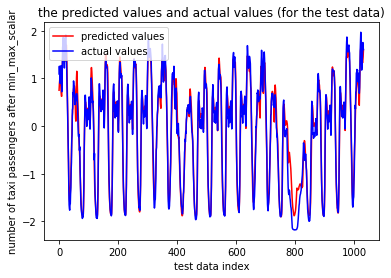

In [62]:
# plot the predicted values and actual values (for the test data)
fig, axs = plt.subplots()

axs.plot(pred_test,color='red', label='predicted values')
axs.plot(y_test,color='blue', label='actual values')
axs.set_title('the predicted values and actual values (for the test data)')

plt.xlabel('test data index')
plt.ylabel('number of taxi passengers after min_max_scalar')
plt.legend(loc='upper left')
plt.show()